In [1]:
cellpose_seg0 = r"output\test\2D_patch_test_0_seg.npy"
cellpose_seg1 = r"output\test\2D_patch_test_1_seg.npy"


In [3]:
import numpy as np
from cellpose import plot, utils, io, models
import matplotlib.pyplot as plt
from skimage.draw import polygon

# Load the segmentation mask
dat_0 = np.load(cellpose_seg0, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_0 = dat_0['masks']
outlines_0 = utils.outlines_list(masks_0) # multiprocessing_threshold=1000



Multiprocessing is disabled for Windows


In [4]:
# Create a blank binary image to fill in the cells
filled_image_0 = np.zeros_like(masks_0, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_0:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_0.shape)
    filled_image_0[rr, cc] = 255  # Fill with white (255) inside each contour

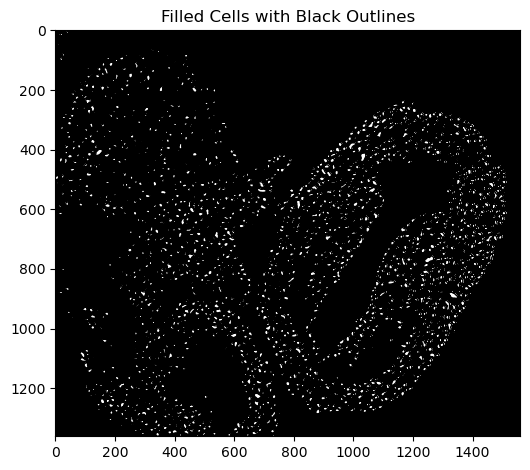

In [5]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_0, cmap='gray', interpolation='none')
for outline in outlines_0:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [6]:
# Load the segmentation mask
dat_1 = np.load(cellpose_seg1, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_1 = dat_1['masks']
outlines_1 = utils.outlines_list(masks_1) # multiprocessing_threshold=1000

Multiprocessing is disabled for Windows


In [7]:
# Create a blank binary image to fill in the cells
filled_image_1 = np.zeros_like(masks_1, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_1:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_1[rr, cc] = 255  # Fill with white (255) inside each contour

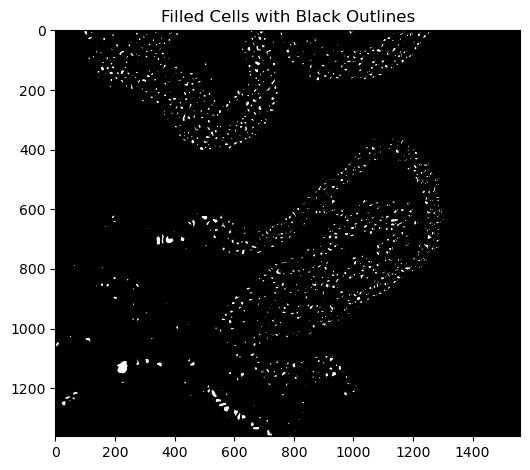

In [8]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_1, cmap='gray', interpolation='none')
for outline in outlines_1:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [72]:
outlines_1[0][0]

array([93,  0])

In [73]:
import numpy as np

# Define offset for Segment 1
offset = np.array([1116, 0])  # Row offset: 1116, Column offset: 0

# Adjust all outlines in outlines_1
adjusted_outlines_1 = []

for outline in outlines_1:
    adjusted_outline = [point + offset for point in outline]  # Add offset to each point
    adjusted_outlines_1.append(np.array(adjusted_outline))  # Store the adjusted outline as a NumPy array

print(f"Adjusted outlines_1[0][0]: {adjusted_outlines_1[0][0]}")


Adjusted outlines_1[0][0]: [1209    0]


In [9]:
# import numpy as np

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (1116, 0),               # No offset for Segment 0
    (0, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []

# Map outlines_1 (Segment 0)
for outline in outlines_0:
    outline = np.array(outline)  # Ensure outline is a NumPy array
    adjusted_outline = outline + offsets[0]  # Apply offset (no change for Segment 0)
    new_outlines.append(adjusted_outline.tolist())

# Map outlines_2 (Segment 1)
for outline in outlines_1:
    print("outline", outline)
    outline = np.array(outline)  # Ensure outline is a NumPy array

    adjusted_outline = outline + offsets[1]  # Apply Segment 1 offset
    print("adjusted_outline", adjusted_outline)
    new_outlines.append(adjusted_outline.tolist())

print(f"Generated {len(new_outlines)} adjusted outlines.")


outline [[ 93   0]
 [ 93   1]
 [ 94   2]
 [ 95   3]
 [ 95   4]
 [ 95   5]
 [ 95   6]
 [ 95   7]
 [ 96   8]
 [ 96   9]
 [ 97  10]
 [ 98  11]
 [ 98  12]
 [ 99  13]
 [100  14]
 [101  15]
 [102  16]
 [103  16]
 [104  17]
 [105  17]
 [106  17]
 [107  17]
 [108  16]
 [109  16]
 [109  15]
 [110  14]
 [110  13]
 [110  12]
 [109  11]
 [109  10]
 [108   9]
 [108   8]
 [108   7]
 [108   6]
 [108   5]
 [108   4]
 [108   3]
 [108   2]
 [109   1]
 [109   0]
 [108   0]
 [107   0]
 [106   0]
 [105   0]
 [104   0]
 [103   0]
 [102   0]
 [101   0]
 [100   0]
 [ 99   0]
 [ 98   0]
 [ 97   0]
 [ 96   0]
 [ 95   0]
 [ 94   0]]
adjusted_outline [[ 93   0]
 [ 93   1]
 [ 94   2]
 [ 95   3]
 [ 95   4]
 [ 95   5]
 [ 95   6]
 [ 95   7]
 [ 96   8]
 [ 96   9]
 [ 97  10]
 [ 98  11]
 [ 98  12]
 [ 99  13]
 [100  14]
 [101  15]
 [102  16]
 [103  16]
 [104  17]
 [105  17]
 [106  17]
 [107  17]
 [108  16]
 [109  16]
 [109  15]
 [110  14]
 [110  13]
 [110  12]
 [109  11]
 [109  10]
 [108   9]
 [108   8]
 [108   7]
 [108 

In [62]:
# import numpy as np

# # Define adjusted main segment coordinates
# segments = [
#     (0, 1362, 0, 1560),   # Segment 0
#     (1116, 2478, 0, 1560) # Segment 1
# ]

# # Offsets for each segment
# offsets = [
#     [0, 0],               # No offset for Segment 0
#     [1116, 0]             # Offset for Segment 1 (row offset, column offset)
# ]

# # Combine outlines with their corresponding offsets
# outlines_list = [outlines_0, outlines_1]  # List of outlines for segments
# new_outlines = []

# # Adjust outlines based on offsets
# for outlines, offset in zip(outlines_list, offsets):
#     for outline in outlines:
#         outline = np.array(outline, dtype=np.int32)  # Ensure outline is a NumPy array
#         adjusted_outline = outline + np.array(offset)  # Apply offset
#         new_outlines.append(adjusted_outline.tolist())  # Convert back to list for storage

# print(f"Generated {len(new_outlines)} adjusted outlines.")


Generated 3122 adjusted outlines.


In [11]:
# Define the shape of the new mask
mask_shape = (2478, 1560)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8) 


# Fill each outline's interior as white
for outline in adjusted_outline:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

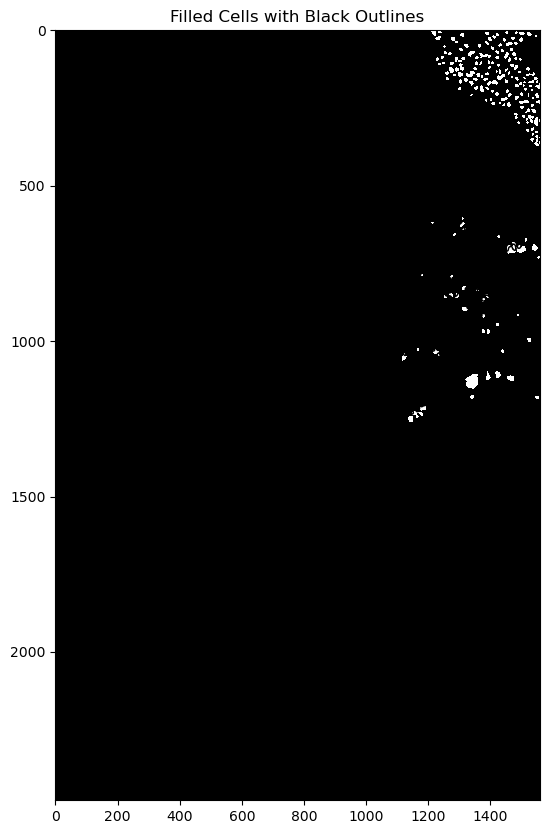

In [80]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')
for outline in outlines_0:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()